<a href="https://colab.research.google.com/github/techwack/NeuroNexus/blob/main/NeuroNexus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

!pip install lightgbm --upgrade

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report,
                            confusion_matrix,
                            roc_auc_score,
                            roc_curve)
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 27.0 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [2]:
from google.colab import files
uploaded = files.upload()

!unzip creditcard.zip
df = pd.read_csv('creditcard.csv')

Saving creditcard.zip to creditcard.zip
Archive:  creditcard.zip
  inflating: creditcard.csv          


Data shape: (284807, 31)

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


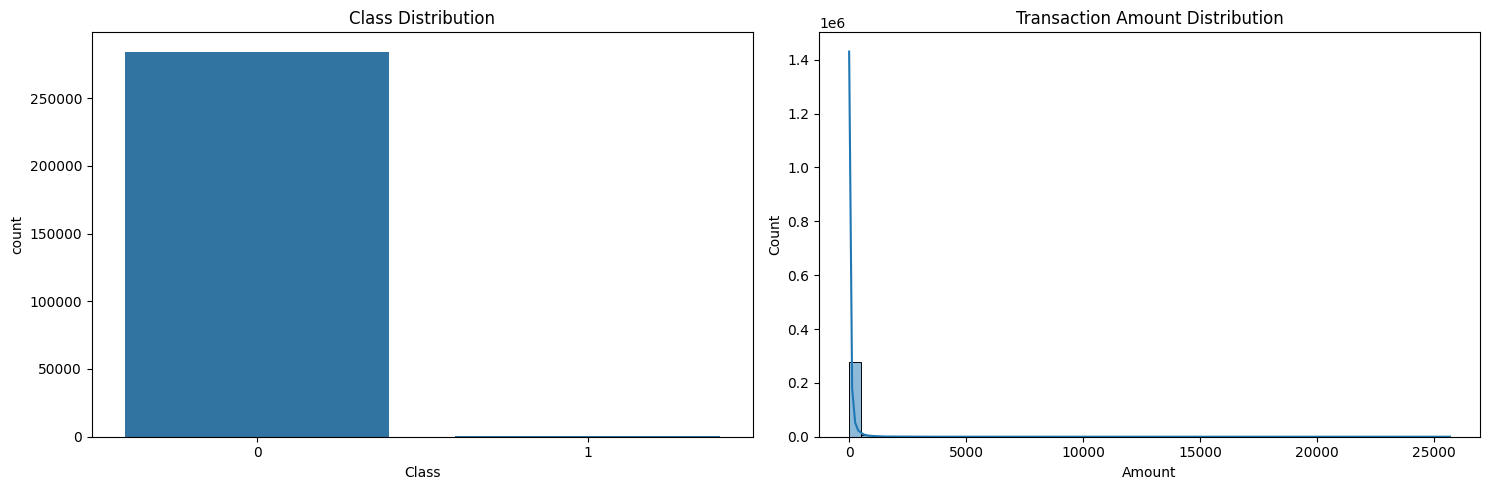

In [3]:
print("Data shape:", df.shape)
print("\nClass distribution:\n", df['Class'].value_counts())

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x='Class', data=df, ax=axes[0])
axes[0].set_title('Class Distribution')
sns.histplot(df['Amount'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Transaction Amount Distribution')
plt.tight_layout()
plt.show()

In [4]:
df = df.drop(['Time'], axis=1)
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

X = df.drop('Class', axis=1)
y = df['Class']

In [5]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LightGBM (GPU)": LGBMClassifier(device='gpu', random_state=42)
}

In [ ]:
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "report": classification_report(y_test, y_pred),
        "matrix": confusion_matrix(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_prob)
    }


Training Logistic Regression...

Training Random Forest...


In [ ]:
for name, result in results.items():
    print(f"\n=== {name} ===")
    print("Classification Report:\n", result["report"])
    print("Confusion Matrix:\n", result["matrix"])
    print("AUC-ROC:", result["auc"])

plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, label=f'{name} (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import fbeta_score
print("F2-Score:", fbeta_score(y_test, y_pred, beta=2))

In [ ]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': models["Random Forest"].feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(10))
plt.title('Top 10 Important Features (Random Forest)')
plt.show()

In [ ]:
print("\nRunning Cross-Validation...")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_resampled, y_resampled,
                              cv=3, scoring='roc_auc')
    print(f"\n{name} CV AUC Scores:", cv_scores)
    print("Mean AUC:", cv_scores.mean())

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)

In [ ]:
best_model = max(results.items(), key=lambda x: x[1]['auc'])
print(f"\n=== BEST MODEL ===\n{best_model[0]} with AUC = {best_model[1]['auc']:.4f}")